In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline  
plt.style.use('ggplot')

N = 100
M = 3

mu_t = [10, 9, 8]
sigma_t = [2, 1.8, 1.6]

mu_c = [9, 8, 7]
sigma_c = [1.3, 1.2, 1.1]

Xc = np.zeros((M, N))
Xt = np.zeros((M, N))

data = np.zeros((6*N, 3))
for i in range(M):
    data[2*i*N:(2*i+1)*N, 0] = mu_t[i] + sigma_t[i]*np.random.randn(N)
    data[2*i*N:(2*i+1)*N, 2] = i * np.ones(N)
    data[(2*i+1)*N:(2*i+2)*N, 0] = mu_c[i] + sigma_c[i]*np.random.randn(N)
    data[(2*i+1)*N:(2*i+2)*N, 1] = 1
    data[(2*i+1)*N:(2*i+2)*N, 2] = i * np.ones(N)
    
    
enc = OneHotEncoder(categorical_features=[1, 2])
enc.fit(data)
data_encoded = enc.transform(data).toarray()

# remove unnecessary factors
data_encoded = np.delete(data_encoded, 0, 1) 
data_encoded = np.delete(data_encoded, 1, 1)
X = data_encoded[:, :-1]
Y = data_encoded[:, -1]
N, M = X.shape

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_32a8648bf08c44ecd039d59963d3fc49 NOW.


Inference for Stan model: anon_model_32a8648bf08c44ecd039d59963d3fc49.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept  10.11  2.7e-3   0.13   9.85  10.02  10.11   10.2  10.37   2417    1.0
beta[0]    -1.16  2.3e-3   0.13  -1.42  -1.25  -1.16  -1.07  -0.91   3080    1.0
beta[1]     -0.9  3.0e-3   0.16  -1.22  -1.01  -0.91   -0.8  -0.59   2926    1.0
beta[2]    -2.25  3.0e-3   0.16  -2.57  -2.36  -2.25  -2.14  -1.93   2989    1.0
sigma       1.61  7.5e-4   0.05   1.52   1.58   1.61   1.65   1.71   4000    1.0
lambda      2.73    0.04   1.89   0.95   1.57   2.18   3.25   7.79   1961    1.0
lp__      -589.4    0.04   1.75 -593.7 -590.4 -589.1 -588.2 -587.0   1824    1.0

Samples were drawn using NUTS at Sat Apr 22 17:32:16 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale 

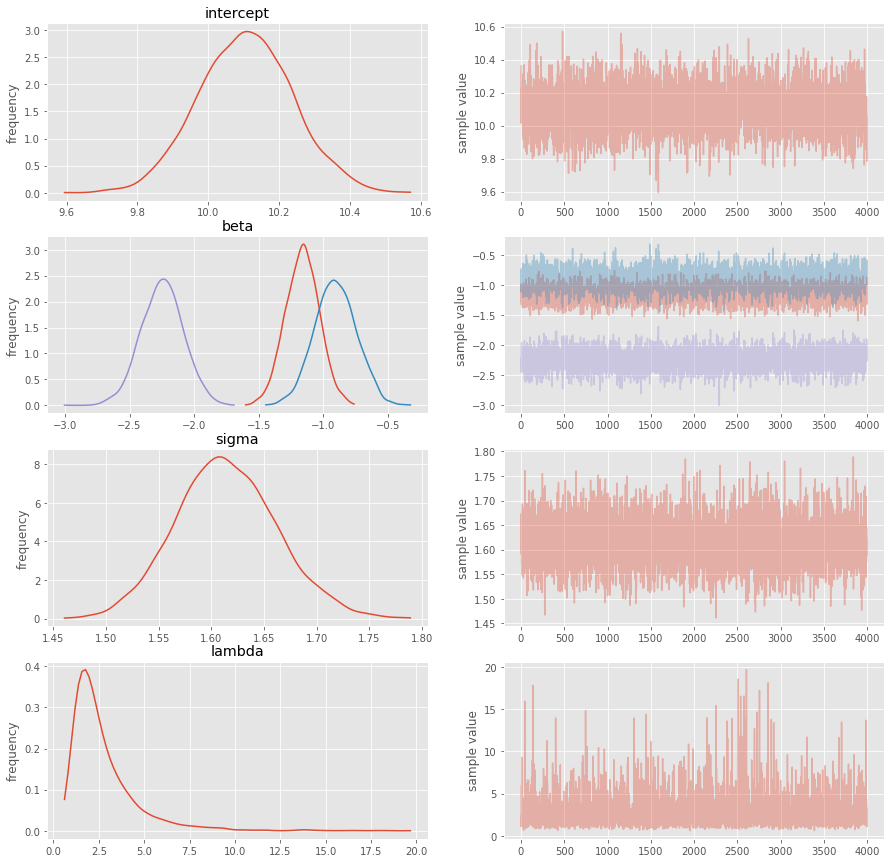

In [12]:
anova_code = """

data {
    int<lower=0> N; // number of samples
    int<lower=0> M; // number of factors
    matrix<lower=0>[N, M] X; // data matrix with categorical factors
    vector<lower=0>[N] Y;
}

parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    real<lower=0> lambda;
}


model {
    // Linear model
    vector[N] Theta;
    Theta = X*beta + intercept;

    // Likelihood
    Y ~ normal(Theta, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ normal(0, lambda);
    sigma ~ cauchy(0, 10);
    lambda ~ cauchy(0, 10);
}
"""

# dictionary containing data
data = {
    'N': N,
    'M': M,
    'X': X,
    'Y': Y
}

# fit model
fit = pystan.stan(model_code=anova_code, data=data, iter=2000, chains=4)
print(fit)
fig = fit.plot()
fig.set_size_inches(15, 15)

In [3]:
#print('P{mu_t > mu_c} = %f' % ((mu_t > mu_c).mean()))